### TSM anomaly scores

In [1]:
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, atan2
from joblib import Parallel, delayed
import math
import os
import ast
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

In [ ]:
def score_agent_group(g):
    # Fill missing train numeric with 0
    for col in ["unique_location_ids_train", "avg_distance_from_home_km_train", "avg_speed_kmh_train",
                "max_stay_duration_train", "transformations_train", "max_distance_from_home_train"]:
        if col in g.columns:
            g[col] = g[col].fillna(0)

    # numeric components
    score_count = (g["unique_location_ids_test"] - g["unique_location_ids_train"]).abs().to_numpy()
    score_dist  = (g["avg_distance_from_home_km_test"] - g["avg_distance_from_home_km_train"]).abs().to_numpy()
    score_speed = (g["avg_speed_kmh_test"] - g["avg_speed_kmh_train"]).abs().to_numpy()

    max_stay        = (g["max_stay_duration_test"] - g["max_stay_duration_train"]).abs().to_numpy()
    transformations = (g["transformations_test"] - g["transformations_train"]).abs().to_numpy()
    max_distance    = (g["max_distance_from_home_test"] - g["max_distance_from_home_train"]).abs().to_numpy()

    dominent_poi_changed = (g["dominent_poi_test"] != g["dominent_poi_train"]).astype(int).to_numpy()

    # set diffs (small per-agent rows; do python lists)
    tl = g["unique_locs_train"].tolist()
    te = g["unique_locs_test"].tolist()
    score_new_locs = np.array([len(set(b) - set(a)) for a, b in zip(tl, te)], dtype=float)

    pt = g["poi_dict_train"].tolist()
    pe = g["poi_dict_test"].tolist()
    score_pois_locs = np.array([len(set(b) - set(a)) for a, b in zip(pt, pe)], dtype=float)

    # weights
    alpha= 0.15248
    beta= -0.0961
    gamma= 0.056233
    delta= 0.01
    a = -0.01
    b = 0.111
    c = 0.6357
    d = 0.043
    e = 0.001

    total = (
        (alpha * score_count) +
        (beta  * score_dist) +
        (gamma * score_speed) +
        (delta * score_new_locs) +
        (a * max_stay) +
        (b * transformations) +
        (c * max_distance) +
        (d * dominent_poi_changed) +
        (e * score_pois_locs)
    )

    return float(np.max(total)) if len(total) else 0.0

In [3]:
LIST_COLS = ["unique_locs", "poi_dict"]

def parse_list_col(s):
    if pd.isna(s) or s == 0:
        return []
    if isinstance(s, list):
        return s
    if isinstance(s, str):
        s = s.strip()
        if not s:
            return []
        try:
            v = ast.literal_eval(s)
            return v if isinstance(v, (list, tuple, set)) else []
        except Exception:
            return []
    return []


train = pd.read_csv('../../processed/train_monthly.csv')
test  = pd.read_csv('../../processed/test_monthly.csv')


for c in ["unique_locs", "poi_dict"]:
    train[c] = train[c].apply(parse_list_col)
    test[c]  = test[c].apply(parse_list_col)

# Keep only agents present in both
common_agents = np.intersect1d(train["agent"].unique(), test["agent"].unique())
train = train[train["agent"].isin(common_agents)]
test  = test[test["agent"].isin(common_agents)]


KEYS = ["agent", "day_type", "time_segment"]
merged = test.merge(train, on=KEYS, how="left", suffixes=("_test", "_train"))


for c in ["unique_locs_train", "poi_dict_train"]:
    if c in merged.columns:
        merged[c] = merged[c].apply(lambda x: x if isinstance(x, list) else [])
for c in ["unique_locs_test", "poi_dict_test"]:
    if c in merged.columns:
        merged[c] = merged[c].apply(lambda x: x if isinstance(x, list) else [])


rows = []
for agent, g in merged.groupby("agent", sort=False):
    rows.append({"agent": agent, "anomaly_score": score_agent_group(g)})

anomaly_df = pd.DataFrame(rows).dropna(subset=["anomaly_score"])

In [4]:
OUT_PATH = "../../processed/anomaly_scores.csv"

run_col = f"new_anomaly_score"

if os.path.exists(OUT_PATH):
    print(f"Existing anomaly_scores.csv found. Appending column: {run_col}")

    existing = pd.read_csv(OUT_PATH)

    merged = existing.merge(
        anomaly_df.rename(columns={"anomaly_score": run_col}),
        on="agent",
        how="outer"
    )

    merged.to_csv(OUT_PATH, index=False)

else:
    print("No anomaly_scores.csv found. Creating new file.")

    gt = pd.read_csv('../../processed/anomalous_agents.csv')
    gt_anomaly_agents = set(gt['agent'].values)
    anomaly_df['is_anomaly'] = anomaly_df['agent'].isin(gt_anomaly_agents).astype(int)
    #anomaly_df.rename(columns={'anomaly_score': 'w_12k'}, inplace=True)
    anomaly_df.to_csv('../../processed/anomaly_scores.csv', index=False)

Existing anomaly_scores.csv found. Appending column: new_anomaly_score


Skipping sum_of_scores (not found)


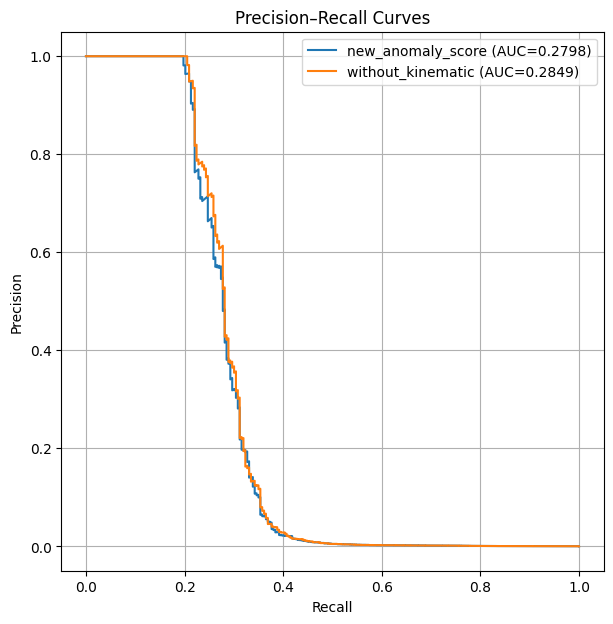

In [5]:
# change this, yours might most probably be 'new_anomaly_score' only
score_cols = [
    "new_anomaly_score",
    "without_kinematic",
    "sum_of_scores"
]

y_true = merged["is_anomaly"].astype(int).values

plt.figure(figsize=(7, 7))

for col in score_cols:
    if col not in merged.columns:
        print(f"Skipping {col} (not found)")
        continue

    # drop rows where this score is NaN
    mask = ~merged[col].isna()
    if mask.sum() == 0:
        print(f"Skipping {col} (all NaN)")
        continue

    precision, recall, thresholds = precision_recall_curve(
        y_true[mask.values],
        merged.loc[mask, col].values
    )

    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{col} (AUC={pr_auc:.4f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves")
plt.legend()
plt.grid(True)
plt.show()
